In [1]:
import pandas as pd
from pylab import *
%matplotlib inline
from scipy.stats import binom

### Introduction

Jakub Vrana was a first-round pick in 2014. He looks like he gets plenty of good opportunities and seems like he has a good shot. But his career shooting percentage is around 9-10% - low for a talented forward.

What is the likelihood that he is actually a good finisher and just has had a string of bad luck to start his career in North America?

### Data

Manually input the data from hockey-reference. (Grabbed Oct 28 2018 and includes postseason.)

In [2]:
#stats from hockey reference
df = pd.DataFrame({'Season': ['2016', '2017', '2017', '2018'],
                  'Type': ['R', 'R', 'P', 'R'],
                  'Goals': [3, 13, 3, 3],
                  'SOG': [32, 133, 39, 24]})
career_g = df.Goals.sum()
career_sog = df.SOG.sum()
career_shpct = career_g / career_sog
print('{0:d} goals on {1:d} sog - {2:.1f}%'.format(career_g, career_sog, career_shpct * 100))

22 goals on 228 sog - 9.6%


We can use a binomial distribution to calculate the likelihood that Vrana would score 22 goals on 228 shots on goal, given a particular "true talent" shooting percentage and treating every shot like an identical coin flip.

We'll try a few different "true talent" shooting percentages - 8%, 9%, 10%, etc.

In [3]:
# calculate probability Vrana scored that many, or fewer, goals, based on his "true talent" sh%
probs = pd.DataFrame({'Successes': list(range(0, career_sog))}) \
    .assign(SOG = career_sog)
probs = pd.concat([probs.assign(SuccessPct = p/100) for p in range(8, 16)])
probs.loc[:, 'Prob'] = [binom.cdf(suc, tri, p) for suc, tri, p in zip(probs.Successes, probs.SOG, probs.SuccessPct)]
probs.head()

,Successes,SOG,SuccessPct,Prob
0,0,228,0.08,5.541466e-09
1,1,228,0.08,1.154070e-07
2,2,228,0.08,1.199733e-06
3,3,228,0.08,8.302850e-06
4,4,228,0.08,4.304636e-05


### Results

We can plot the likelihood that Vrana would score _X_ number of goals on 228 shots on goal with different shooting percentages.

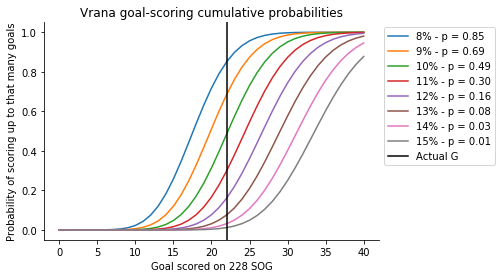

In [4]:
for shpct in probs.SuccessPct.unique():
    temp = probs.query('SuccessPct == {0} & Successes <= 40'.format(shpct))
    myprob = temp.query('Successes == {0:d}'.format(career_g)).Prob.iloc[0]
    plot(temp.Successes, temp.Prob, label = '{0:.0f}% - p = {1:.2f}'.format(100 * shpct, myprob))
axvline(x = career_g, label = 'Actual G', color = 'k')
legend(loc = 2, bbox_to_anchor = (1, 1))
xlabel('Goal scored on {0:d} SOG'.format(career_sog))
ylabel('Probability of scoring up to that many goals')
title('Vrana goal-scoring cumulative probabilities');
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

So if Vrana is a "true talent" 8% shooter, the probability he'd have scored only 22 goals on 228 shots on goal is 85%. If he's a "true talent" 15% shooter (which would essentially be the best in the league for a non-netfront, non-power play player), there's only a 1% chance he'd have scored this little. But there is some middle ground - he could be a 12% shooter (decent) and there's still a 1-in-8 chance we'd be seeing a result like this.

### Bayesian data

We can kind of "sum up" over these different "prior beliefs" about Vrana's shooting percentage to calculate a range of probabilities of what his "true talent" shooting percentage is. (I wrote something similar to this [about Sidney Crosby](https://github.com/muneebalam/Hockey/blob/master/NHL/Posts/Crosby%20Bayesian%20scoring.ipynb) a few years ago.) In statistics, this would be called the Bayesian approach.

Assuming every shot is an identical coin flip, the most important thing here is to get a good set of "prior beliefs" about what his shooting percentage should be. There are several reasonable-sounding approaches we could take. For example:

- Uninformative
- Top-nine forward
- Top-six forward
- Top-line forward

There are other approaches we could take -- look at mid-first-round wingers, skilled wingers who don't get much PP time, etc. But there are some complications there and I want to keep things simple for now.

First, let's grab 5v5 shooting data from [Corsica](corsica.hockey) and look at Vrana's 5v5 totals.

In [5]:
# Filters - all years since 2013-14, min TOI 50, no aggregation, forwards only, include playoffs. Individual stats view
fives = pd.read_csv('skater_stats_2018-10-28.csv')[['Player', 'Season', 'Team', 'Position', 'GP', 'G', 'iSF', 'iSh%', 'TOI']]
fives.head(10) # sometimes SF means saves, but here, it means shots on goal

,Player,Season,Team,Position,GP,G,iSF,iSh%,TOI
0,5EBASTIAN.AHO,2017-2018,NYI,D/R,12,0,10,0.00,170.17
1,AARON.VOLPATTI,2013-2014,WSH,L,41,2,18,11.11,299.49
2,ADAM.BURISH,2013-2014,S.J,R,15,0,9,0.00,124.80
3,ADAM.BURISH,2014-2015,S.J,R,20,1,20,5.00,187.47
4,ADAM.CRACKNELL,2013-2014,STL,R,24,1,22,4.55,212.42
5,ADAM.CRACKNELL,2014-2015,CBJ,R,17,0,15,0.00,157.46
6,ADAM.CRACKNELL,2015-2016,VAN/EDM,R,52,5,66,7.58,586.50
7,ADAM.CRACKNELL,2016-2017,DAL,R,69,9,78,11.54,676.03
8,ADAM.ERNE,2016-2017,T.B,L,26,3,36,8.33,278.82
9,ADAM.ERNE,2017-2018,T.B,L,23,3,29,10.34,226.20


In [6]:
vrana_5v5 = fives \
    [fives.Player == 'JAKUB.VRANA'] \
    [['Player', 'GP', 'G', 'iSF', 'TOI']] \
    .groupby('Player') \
    .sum() \
    .assign(ShPct = lambda x: x.G / x.iSF)
vrana_5v5_sh = vrana_5v5.ShPct.iloc[0]
vrana_5v5.head()

,GP,G,iSF,TOI,ShPct
Player,,,,,
JAKUB.VRANA,126,16,204,1424.54,0.078431


One of the complications of trying to derive a "prior belief" empirically is that things change over time. Check out the shooting percentages by season:

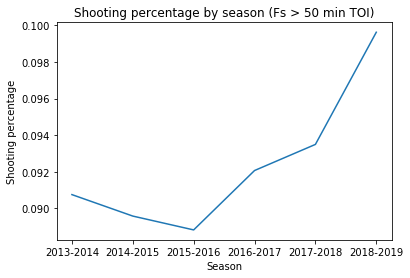

In [7]:
temp = fives.groupby('Season').sum()
temp.loc[:, 'ShPct'] = temp.G / temp.iSF
plot(temp.index, temp.ShPct)
xlabel('Season');
ylabel('Shooting percentage');
title('Shooting percentage by season (Fs > 50 min TOI)');

Let's ignore that change, to keep things simple, and just remember that whatever results we get in the end, we should shift upward a bit, since shooters nowadays (especially the last couple of years) have converted at a slightly higher rate.

Next, we'll try a few different "prior beliefs." Making inferences based on those prior beliefs is easiest when they follow a [nice distribution](https://en.wikipedia.org/wiki/Conjugate_prior).

#### Prior - uninformative

An uninformative (or uniform) prior is just a flat distribution. It's just as likely that Vrana is a "true talent" 95% shooter as he is a 10% shooter. The beta distribution (kind of like the "sum" of binomial distributions) has parameters alpha = 1, beta = 1 in this case.

To take into account our data on what Vrana has done, we simply add the successes (goals scored) to alpha and the failures (SOG minus goals) to beta. That gives us the updated belief, the posterior.

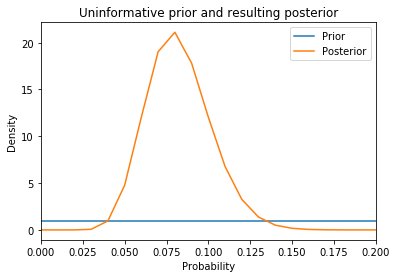

In [8]:
from scipy.stats import beta
myplotdf = pd.DataFrame({'Probability': arange(0, 1, 0.01)})
myplotdf.loc[:, 'Prior'] = beta.pdf(myplotdf.Probability, 1, 1)
myplotdf.loc[:, 'Posterior'] = beta.pdf(myplotdf.Probability, 1 + 16, 1 + 204 - 16) # 16 and 204 from above

plot(myplotdf.Probability, myplotdf.Prior, label = 'Prior');
plot(myplotdf.Probability, myplotdf.Posterior, label = 'Posterior'); # 16 and 204 from above
ylabel('Density');
xlabel('Probability');
title('Uninformative prior and resulting posterior');
legend(loc = 1);
xlim(0, 0.2);

This plot is like a histogram of Vrana's predicted "true talent" shooting percentage. The prior is uniform - so any value is equally likely. 

The way to think about the alpha and beta values for the beta distribution is like a "head start." So in the uniform prior, you give a "head start" of one success (goal) and one failure (saved shot). Then, you add the observed results.

When we bring results into the picture, we think his true talent is likeliest around 8%, but it's kind of like a normal distribution centered around 8% and with a standard deviation around 1-1.5%. So there's still some chance that it's as high as 11%, which is still pretty good.

#### Prior - top nine forwards

We'll look at forwards who were in the top 270 in TOI/gm by season, minimum 40 GP. Then, we'll take all of their seasons and sum over them, and calculate the shooting percentage. Finally, we'll set a high-ish cutoff for minimum SOG. (In a single season, a good player may only get 200 shots on goal. Those low Ns increase the variance of the result, and we want "true talent" shooting percentage.)

We'll keep it at forwards, and not restrict to wingers, because of the complication of many players playing wing at times and center at other times. We'll also pick 270 (9 top-nine forwards times 30 teams) and not increase it to 279 in 2017-18, to keep it simple.

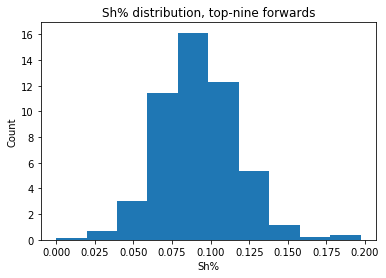

In [9]:
def filter_for_top_n(n):
    fwdn = n * 30
    allps = fives \
        .query('GP >= 40') \
        .assign(TOIGm = lambda x: x.TOI / x.GP) \
        .sort_values('TOIGm', ascending = False) \
        .groupby('Season', as_index = False) \
        .head(fwdn) \
        [['Player']] \
        .drop_duplicates()
    return fives \
        .merge(allps, how = 'inner', on = 'Player') \
        .groupby('Player', as_index = False) \
        .sum() \
        .assign(ShPct = lambda x: x.G / x.iSF)

topnine = filter_for_top_n(9)

hist(topnine['ShPct'], normed = True)
title('Sh% distribution, top-nine forwards');
xlabel('Sh%');
ylabel('Count');

This distributions is "nice".

Let's fit a beta distribution.

In [10]:
def betafit(mydf):
    nozero = mydf[mydf['ShPct'] > 0]
    print('Dropped {0:d} values because sh% was zero'.format(len(mydf) - len(nozero)))
    betafit = beta.fit(nozero['ShPct'].values, floc = 0, fscale = 1)
    return betafit

topnine_betafit = betafit(topnine)
print('Beta fit: alpha = {0:.1f} and beta = {1:.1f}'.format(topnine_betafit[0], topnine_betafit[1]))

Dropped 1 values because sh% was zero
Beta fit: alpha = 12.4 and beta = 121.7


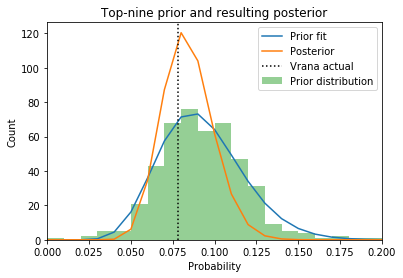

In [11]:
def plot_prior_post(mydf, mybeta, lab):
    myplotdf.loc[:, 'Prior'] = beta.pdf(myplotdf.Probability, mybeta[0], mybeta[1])
    myplotdf.loc[:, 'Posterior'] = beta.pdf(myplotdf.Probability, mybeta[0] + 16, mybeta[1] + 204 - 16)

    plot(myplotdf.Probability, myplotdf.Prior * len(mydf)/100, label = 'Prior fit');
    plot(myplotdf.Probability, myplotdf.Posterior * len(mydf)/100, label = 'Posterior'); # 16 and 204 from above
    hist(mydf['ShPct'], bins = arange(0, 1, 0.01), label = 'Prior distribution', alpha = 0.5)
    axvline(x = vrana_5v5_sh, label = 'Vrana actual', color = 'k', ls = ':')
    ylabel('Count');
    xlabel('Probability');
    title('{0:s} prior and resulting posterior'.format(lab));
    legend(loc = 1);
    xlim(0, 0.2);
plot_prior_post(topnine, topnine_betafit, 'Top-nine')

This is pretty similar to before - we're still thinking he's likeliest around 8%, and we're 95% confident he's between 5.5% and 11%. (See table below.)

In [12]:
confdf = pd.DataFrame({'Confidence': arange(0, 1, 0.05)}) \
    .assign(ShPct_up_to_Uniform = lambda x: beta.ppf(x.Confidence, 1 + 16, 1 + 204 - 16),
           ShPct_up_to_TopNine = lambda x: beta.ppf(x.Confidence, topnine_betafit[0] + 16, topnine_betafit[1] + 204 - 16))
confdf.head(20)

,Confidence,ShPct_up_to_Uniform,ShPct_up_to_TopNine
0,0.00,0.000000,0.000000
1,0.05,0.053527,0.060700
2,0.10,0.059011,0.065287
3,0.15,0.062909,0.068503
4,0.20,0.066121,0.071128
5,0.25,0.068958,0.073430
6,0.30,0.071570,0.075536
7,0.35,0.074044,0.077521
8,0.40,0.076441,0.079434
9,0.45,0.078805,0.081312


#### Prior - top six or top line forwards

Let's narrow top nine to top six or top line.

Dropped 0 values because sh% was zero
Dropped 0 values because sh% was zero


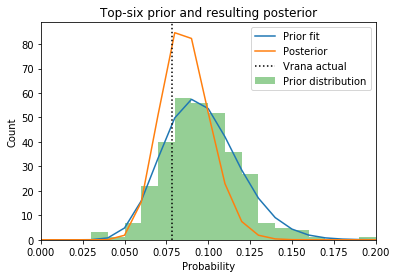

In [13]:
topsix = filter_for_top_n(6)
topline = filter_for_top_n(3)

topsix_betafit = betafit(topsix)
topline_betafit = betafit(topline)
  
plot_prior_post(topsix, topsix_betafit, 'Top-six')

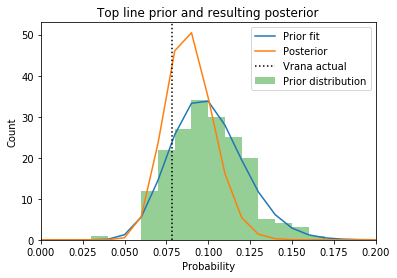

In [14]:
plot_prior_post(topline, topline_betafit, 'Top line')

In [15]:
confdf = confdf \
    .assign(ShPct_up_to_TopSix = lambda x: beta.ppf(x.Confidence, topsix_betafit[0] + 16, topsix_betafit[1] + 204 - 16),
            ShPct_up_to_TopLine = lambda x: beta.ppf(x.Confidence, topline_betafit[0] + 16, topline_betafit[1] + 204 - 16))
confdf.head(20)

,Confidence,ShPct_up_to_Uniform,ShPct_up_to_TopNine,ShPct_up_to_TopSix,ShPct_up_to_TopLine
0,0.00,0.000000,0.000000,0.000000,0.000000
1,0.05,0.053527,0.060700,0.064001,0.066562
2,0.10,0.059011,0.065287,0.068476,0.070999
3,0.15,0.062909,0.068503,0.071604,0.074095
4,0.20,0.066121,0.071128,0.074154,0.076614
5,0.25,0.068958,0.073430,0.076385,0.078818
6,0.30,0.071570,0.075536,0.078424,0.080829
7,0.35,0.074044,0.077521,0.080343,0.082721
8,0.40,0.076441,0.079434,0.082191,0.084541
9,0.45,0.078805,0.081312,0.084002,0.086325


Text(0.5,0.98,"Confidence Vrana's true talent sh% is at least...")

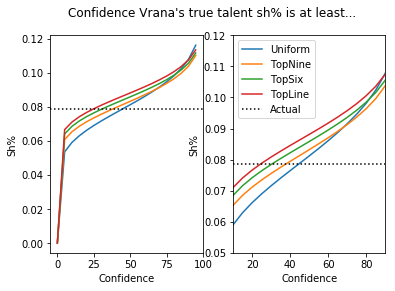

In [16]:
temp = confdf \
    .melt('Confidence', var_name = 'Prior', value_name = 'ShPct') \
    .assign(Prior = lambda x: x.Prior.str.extract('ShPct_up_to_([A-Za-z]+)', expand = False))

fig, axes = subplots(1, 2, sharex = False, sharey = False)

for prior in temp.Prior.unique():
    temp2 = temp.query('Prior == \'{0:s}\''.format(prior))
    axes[0].plot(temp2.Confidence * 100, temp2.ShPct, label = prior);
axes[0].axhline(y = vrana_5v5_sh, label = 'Actual', color = 'k', ls = ':');
axes[0].set_xlabel('Confidence');
axes[0].set_ylabel('Sh%');

for prior in temp.Prior.unique():
    temp2 = temp.query('Prior == \'{0:s}\''.format(prior))
    axes[1].plot(temp2.Confidence * 100, temp2.ShPct, label = prior);
axes[1].set_xlabel('Confidence');
axes[1].set_ylabel('Sh%');
axes[1].set_xlim(10, 90);
axes[1].set_ylim(0.05, 0.12);
axes[1].axhline(y = vrana_5v5_sh, label = 'Actual', color = 'k', ls = ':');
axes[1].legend(loc = 2);

fig.suptitle('Confidence Vrana\'s true talent sh% is at least...')

There's definitely some movement here. The "basement" for Vrana gets higher as we get more optimistic with our prior beliefs, which makes sense - if we think he's a top line player, then he should finish better, and it's more likely that what we've seen so far is some bad luck.

Regardless of the prior, we infer Vrana is somewhere between 6.5% or so and 11% or so at 5-on-5. Given his 200+ shots on goal, that could mean his true talent is a couple of goals fewer than what he does have, or perhaps six more.

Vrana does have other avenues to score more. His shot rate is up to 2.4 per game this season, up from 1.5-1.8 earlier. His TOI is up to 15 per game, up from 11-13 before. He'll get more time with Backstrom and Kuznetsov this season. We also haven't considered the PP here - the Caps' PP isn't a good goal-scoring environment for left-handed shooters, especially 2nd-unit left shots. But on other teams, in other systems, he may add some more PPGs.

But with a shooting percentage of around 10% and taking 2.4 shots per game, he'll need to play the entire year just to get to 20 goals. That's good, but it feels like he could offer more.